In [20]:
import numpy as np
import pandas as pd
import seaborn as sns

In [21]:
'''This notebook takes the cleaned future Caltrain timetables output from Future_schedule_cleaning.ipynb,
processes them to hourly summaries, and exports to CSV'''

'This notebook takes the cleaned future Caltrain timetables output from Future_schedule_cleaning.ipynb,\nprocesses them to hourly summaries, and exports to CSV'

In [22]:
df = pd.read_csv('../data/parsed_data/schedules/future_schedules_cleaned.csv')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15928 entries, 0 to 15927
Data columns (total 7 columns):
km          15928 non-null int64
station     15928 non-null object
train_id    15928 non-null object
time        15928 non-null int64
hr          15928 non-null int64
min         15928 non-null int64
scenario    15928 non-null object
dtypes: int64(4), object(3)
memory usage: 871.1+ KB


In [24]:
df.head()

,km,station,train_id,time,hr,min,scenario
0,78,SAN JOSE,IC (HSR) 701_single_1,348,5,48,Baseline SB
1,126,GILROY (HSR) $,IC (HSR) 701_single_1,373,6,13,Baseline SB
2,0,SALESFORCE TRANSIT CENTER (STC) $,HSR 801_single_2,310,5,10,Baseline SB
3,24,MILLBRAE,HSR 801_single_2,330,5,30,Baseline SB
4,78,SAN JOSE,HSR 801_single_2,365,6,5,Baseline SB


In [25]:
def get_station_pairs(df):
    
    df = df.copy()
    
    #Get departure and arrival stop info
    df_stops_arr = df.copy()
    df = df.rename(columns={"station": "departure_station",
                                        "time": "departure_time",
                                        "hr": "departure_hour",
                                        "min": "departure_minute",
                                        "km": "departure_km"})
    
    df_stops_arr = df_stops_arr.rename(columns={"station": "arrival_station",
                                        "time": "arrival_time",
                                        "hr": "arrival_hour",
                                        "min": "arrival_minute",
                                        "km": "arrival_km"})

    #Join the two on train ID and scenario
    df = df.merge(df_stops_arr, on=['scenario', 'train_id'])

    #Thow out any journeys that do not go forwards in time
    df = df[df['arrival_time'] > df['departure_time']]

    #Add trip duration column
    df['trip_duration'] = df['arrival_time'] - df['departure_time']
    
    #Add trip distance column
    df['trip_length'] = df['arrival_km'] - df['departure_km']
    
    df = df.reset_index(drop=True)

    return df

df_pairs = get_station_pairs(df)

In [26]:
df_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83807 entries, 0 to 83806
Data columns (total 14 columns):
departure_km         83807 non-null int64
departure_station    83807 non-null object
train_id             83807 non-null object
departure_time       83807 non-null int64
departure_hour       83807 non-null int64
departure_minute     83807 non-null int64
scenario             83807 non-null object
arrival_km           83807 non-null int64
arrival_station      83807 non-null object
arrival_time         83807 non-null int64
arrival_hour         83807 non-null int64
arrival_minute       83807 non-null int64
trip_duration        83807 non-null int64
trip_length          83807 non-null int64
dtypes: int64(10), object(4)
memory usage: 9.0+ MB


In [27]:
df_pairs.head()

,departure_km,departure_station,train_id,departure_time,departure_hour,departure_minute,scenario,arrival_km,arrival_station,arrival_time,arrival_hour,arrival_minute,trip_duration,trip_length
0,78,SAN JOSE,IC (HSR) 701_single_1,348,5,48,Baseline SB,126,GILROY (HSR) $,373,6,13,25,48
1,0,SALESFORCE TRANSIT CENTER (STC) $,HSR 801_single_2,310,5,10,Baseline SB,24,MILLBRAE,330,5,30,20,24
2,0,SALESFORCE TRANSIT CENTER (STC) $,HSR 801_single_2,310,5,10,Baseline SB,78,SAN JOSE,365,6,5,55,78
3,0,SALESFORCE TRANSIT CENTER (STC) $,HSR 801_single_2,310,5,10,Baseline SB,126,GILROY (HSR) $,391,6,31,81,126
4,24,MILLBRAE,HSR 801_single_2,330,5,30,Baseline SB,78,SAN JOSE,365,6,5,35,54


In [28]:
df_journey_times = df_pairs.groupby(['scenario', 'departure_station', 'arrival_station', 'departure_hour'])\
    .agg(['count', 'mean', 'min', 'max'])['trip_duration']\
    .reset_index()

In [29]:
df_journey_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29297 entries, 0 to 29296
Data columns (total 8 columns):
scenario             29297 non-null object
departure_station    29297 non-null object
arrival_station      29297 non-null object
departure_hour       29297 non-null int64
count                29297 non-null int64
mean                 29297 non-null float64
min                  29297 non-null int64
max                  29297 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 1.8+ MB


In [30]:
df_journey_times.head()

,scenario,departure_station,arrival_station,departure_hour,count,mean,min,max
0,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,6,3,8.666667,8,9
1,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,7,4,8.500000,8,9
2,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,8,4,8.500000,8,9
3,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,9,4,8.500000,8,9
4,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,10,4,8.500000,8,9


In [31]:
def cartesian_product( lsts ):
    """
    Returns Pandas DataFrame containing cartesian product of lists. This is the
    same as itertools.product, but faster.
    """

    ret = None

    for lst in lsts:
        subtable = pd.DataFrame(lst)
        subtable["key"] = 1

        if ret is None:
            ret = subtable
        else:
            ret = ret.merge(subtable, on="key")

    # they 'key' column was just a trick to get a set product; it's no longer needed
    ret = ret.drop("key", axis=1)

    return ret

In [32]:
def get_wait_times(df, verbose=True):
    """
    Finds parameter estimates for the distribution of travel times for all
    sets of (start_time, route_name, origin_stop, destination_stop) present in
    the input dataframe.
    Args:
        df (DataFrame): DataFrame in format returned by `stops_to_durations`.
    Returns:
        (DataFrame): Contains distribution parameters of fit beta
        distribution for all (start_time, route_name, origin_stop,
        destination_stop) present in `df`.
    """
    
    df = df.copy()

    # we'll construct a dataframe with those unique combinations of origin
    # stop, destination stop, and departure time
    if verbose: print( "finding all time slices..." )
    df_timestamps = cartesian_product( [df['scenario'].unique(),
                                        df['departure_station'].unique(),
                                        df['arrival_station'].unique(),
                                        df['departure_hour'].unique(),
                                        np.arange(0,60)] )
    df_timestamps.columns = ["scenario", "departure_station", "arrival_station", "passenger_at_station_hour", "passenger_at_station_minute"]
    # the `departure_hour` and `minute` columns are a means towards
    # a `passenger_at_station_time` column
    df_timestamps['passenger_at_station_time'] = df_timestamps['passenger_at_station_hour']*60 + df_timestamps['passenger_at_station_minute']

    # Get every depart/arrival/time combination and sort them so that
    # depart+arrive are adjacent and in chronological order. Then, take
    # the observed journey times, and fill in corresponding time/block rows.
    if verbose: print( "merging with observed journeys...")
    df_timestamps = df_timestamps.sort_values(['scenario', 'departure_station', 'arrival_station', 'passenger_at_station_time'])
    df_timestamps = df_timestamps.reset_index(drop=True)
    
    #We need to merge passenger_at_station_time onto departure_time,
    #but we also need to preserve departure_time, so make a copy of it
    df['passenger_at_station_time'] = df['departure_time']

    df = df_timestamps.merge(df, on=['scenario', 'passenger_at_station_time', 'departure_station', 'arrival_station'], how='left')
    
    # Backfill so each minute has the data for the next departure. Thus each
    # row contains a minute of the day, the next arrival, and the journey time
    # for that trip.
    if verbose: print( "backfilling time slices with next journey..." )
    df = df.groupby(['scenario', 'departure_station', 'arrival_station']).apply(lambda group: group.fillna(method='bfill'))

    #Add journey time columns
    df['wait_time'] = df['departure_time'] - df['passenger_at_station_time']

    
    #Drop NaNs (occurs at the end of the data set when we don't know when the next train will come.)
    df = df.dropna(subset=['wait_time'])
    
    if verbose: print( "calculating aggregates..." )
    #Group to get results by scenario, station pair, and passenger arrival hour
    df = df.groupby(['scenario', 'departure_station', 'arrival_station', 'passenger_at_station_hour'])\
        .agg(['count', 'mean', 'min', 'max'])['wait_time']\
        .reset_index()
    
    #Rename 'passenger_at_station_hour' for consistancy with other dataframes
    df.rename(columns={'passenger_at_station_hour': 'departure_hour'}, inplace=True)
    
    return df
df_wait_times = get_wait_times(df_pairs)

finding all time slices...
merging with observed journeys...
backfilling time slices with next journey...
calculating aggregates...


In [33]:
df_wait_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34866 entries, 0 to 34865
Data columns (total 8 columns):
scenario             34866 non-null object
departure_station    34866 non-null object
arrival_station      34866 non-null object
departure_hour       34866 non-null int64
count                34866 non-null int64
mean                 34866 non-null float64
min                  34866 non-null float64
max                  34866 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 2.1+ MB


In [34]:
df_wait_times.head()

,scenario,departure_station,arrival_station,departure_hour,count,mean,min,max
0,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,4,60,115.5,86.0,145.0
1,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,5,60,55.5,26.0,85.0
2,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,6,60,10.5,0.0,25.0
3,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,7,60,9.7,0.0,23.0
4,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,8,60,9.7,0.0,23.0


In [35]:
#Finally, merge journey times and wait times together
df_final = df_journey_times.merge(df_wait_times,
                       on=['scenario', 'departure_station', 'arrival_station', 'departure_hour'],
                       suffixes=['_journey_time', '_wait_time'])

In [36]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29297 entries, 0 to 29296
Data columns (total 12 columns):
scenario              29297 non-null object
departure_station     29297 non-null object
arrival_station       29297 non-null object
departure_hour        29297 non-null int64
count_journey_time    29297 non-null int64
mean_journey_time     29297 non-null float64
min_journey_time      29297 non-null int64
max_journey_time      29297 non-null int64
count_wait_time       29297 non-null int64
mean_wait_time        29297 non-null float64
min_wait_time         29297 non-null float64
max_wait_time         29297 non-null float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.9+ MB


In [37]:
df_final.head()

,scenario,departure_station,arrival_station,departure_hour,count_journey_time,mean_journey_time,min_journey_time,max_journey_time,count_wait_time,mean_wait_time,min_wait_time,max_wait_time
0,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,6,3,8.666667,8,9,60,10.5,0.0,25.0
1,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,7,4,8.500000,8,9,60,9.7,0.0,23.0
2,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,8,4,8.500000,8,9,60,9.7,0.0,23.0
3,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,9,4,8.500000,8,9,60,9.7,0.0,23.0
4,Baseline NB,22nd STREET,SALESFORCE TRANSIT CENTER (STC) $,10,4,8.500000,8,9,60,9.7,0.0,23.0


In [38]:
df_final.to_csv('../data/parsed_data/schedules/future_schedules_metrics.csv', index=False)

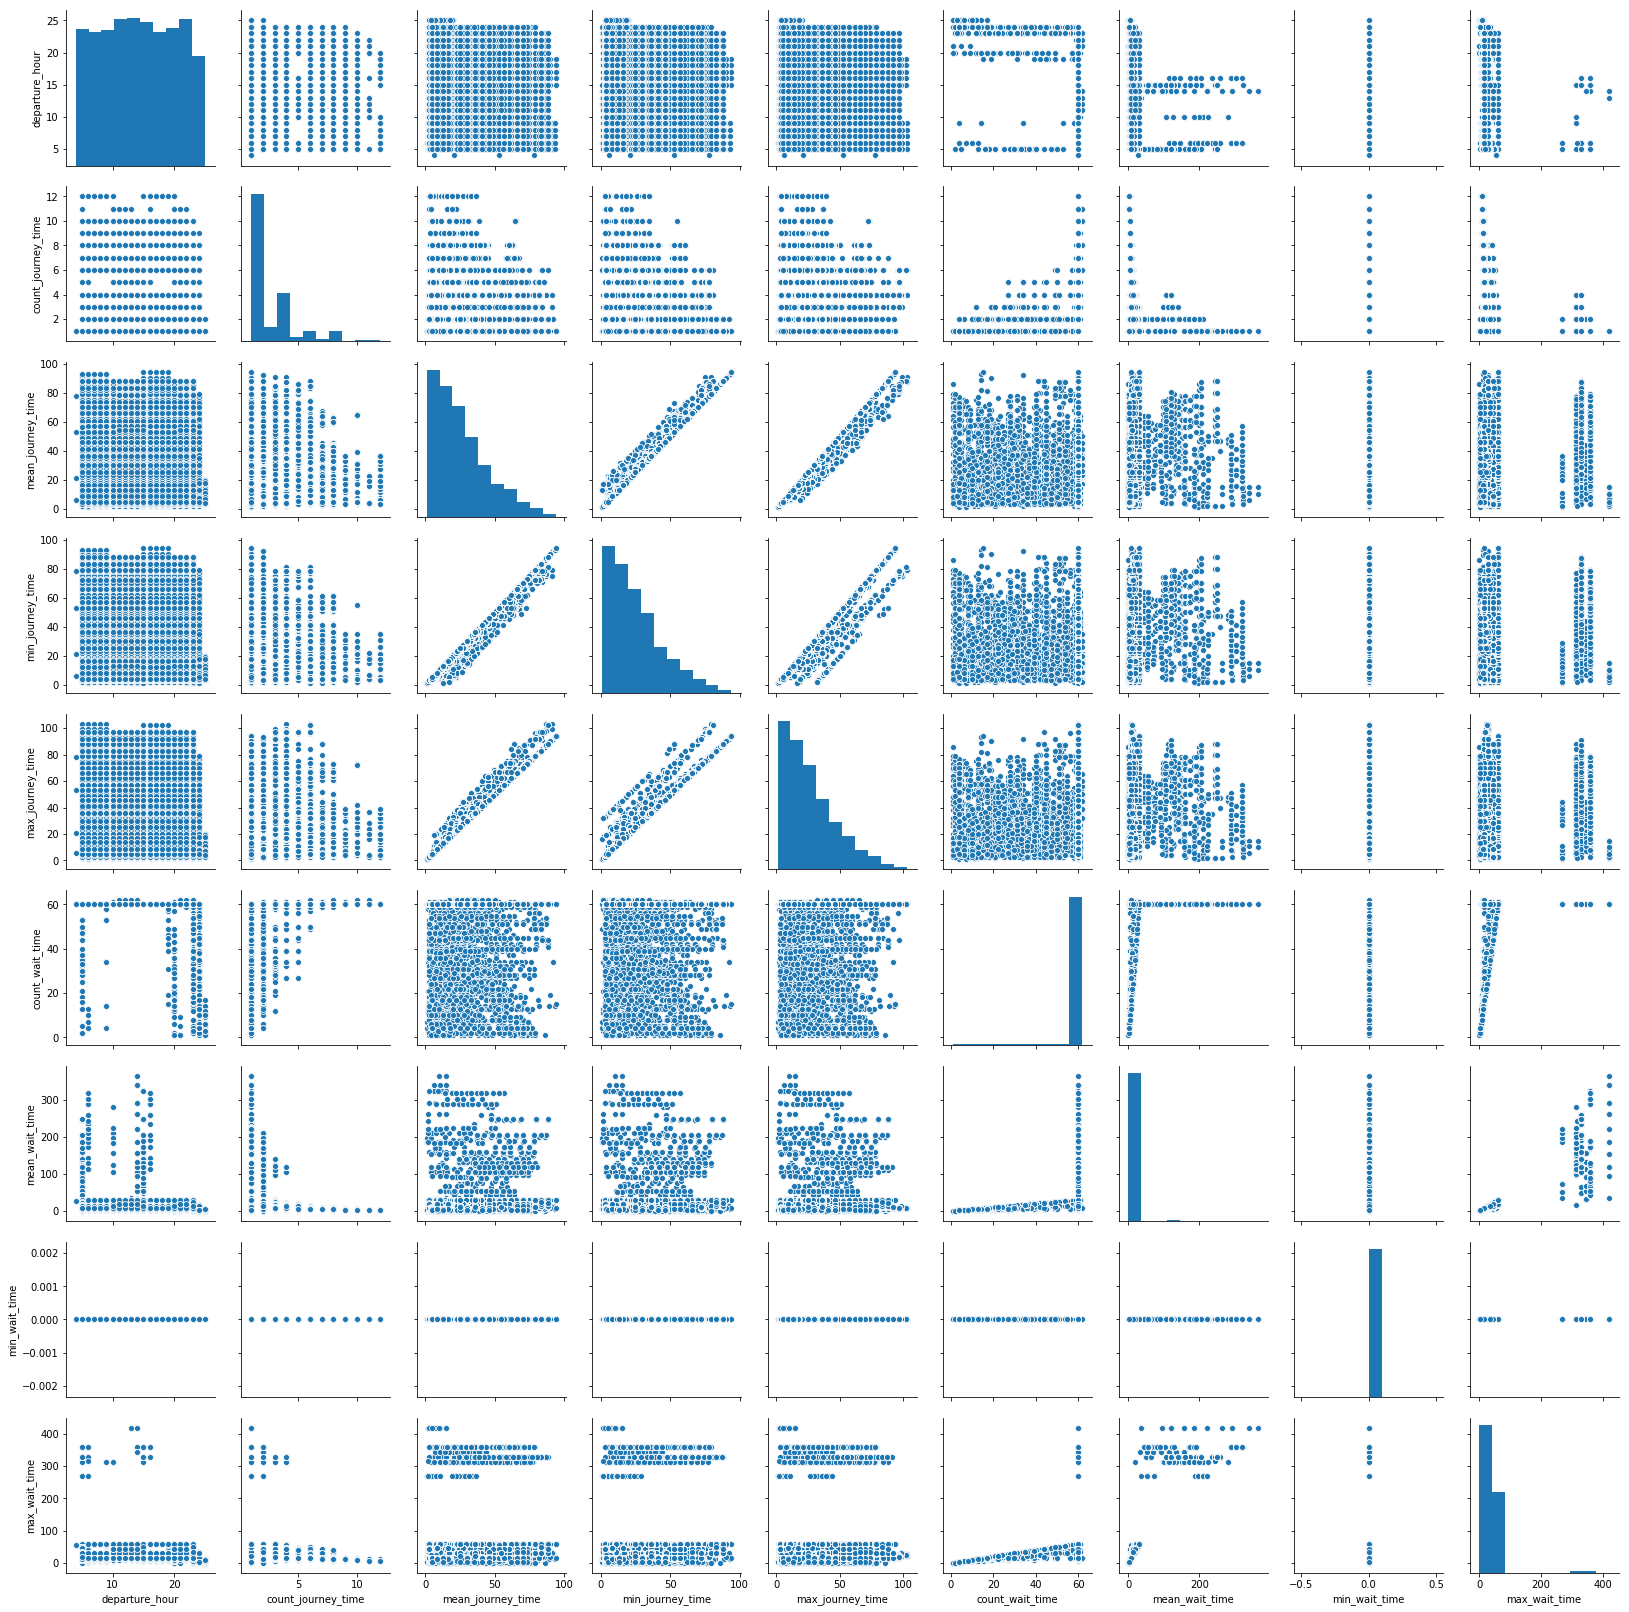

In [39]:
sns.pairplot(df_final)

In [ ]:
'''
Hour
origin_id
origin_name
dest_id
scenario
Min Wait at Origin Station
Average Wait at Origin Station
Max Wait at Origin Station
Min Length of Journey
Average Length of Journey
Max Length of Journey
CO2 Emissions
Ridership Number
'''